# Twitter Sentiment Analysis

The objective of this task is to detect hate speech in tweets. For the sake of simplicity, we say a tweet contains hate speech if it has a racist or sexist sentiment associated with it. So, the task is to classify racist or sexist tweets from other tweets.

Formally, given a training sample of tweets and labels, where label '1' denotes the tweet is racist/sexist and label '0' denotes the tweet is not racist/sexist, your objective is to predict the labels on the test dataset.

# Import libraries

In [1]:
import pandas as pd
import numpy as np
import re
import string
import nltk

from wordcloud import WordCloud, STOPWORDS #importing word cloud
from collections import defaultdict
from sklearn.feature_extraction.text import CountVectorizer 
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error # the main evaluation metric
from sklearn import metrics

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
train = pd.read_csv(r"C:\Users\91901\Documents\Python\Twitter_ds\train.csv")#import the training test
test = pd.read_csv(r"C:\Users\91901\Documents\Python\Twitter_ds\test.csv") #import test set

In [3]:
train.info() #check for the count and the null objects in each feature

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31962 entries, 0 to 31961
Data columns (total 3 columns):
id       31962 non-null int64
label    31962 non-null int64
tweet    31962 non-null object
dtypes: int64(2), object(1)
memory usage: 749.2+ KB


In [4]:
train.head() #view the training set 

,id,label,tweet
0,1,0,@user when a father is dysfunctional and is s...
1,2,0,@user @user thanks for #lyft credit i can't us...
2,3,0,bihday your majesty
3,4,0,#model i love u take with u all the time in ...
4,5,0,factsguide: society now #motivation


# Feature Engineering

In [5]:
import re
def remove_pattern(input_txt, pattern):
    r = re.findall(pattern, input_txt)
    for i in r:
        input_txt = re.sub(i, '', input_txt)
        
    return input_txt
train['tweet'] = np.vectorize(remove_pattern)(train['tweet'], "@[\w]*") 
test['tweet'] = np.vectorize(remove_pattern)(test['tweet'], "@[\w]*") 
train.head()

,id,label,tweet
0,1,0,when a father is dysfunctional and is so sel...
1,2,0,thanks for #lyft credit i can't use cause th...
2,3,0,bihday your majesty
3,4,0,#model i love u take with u all the time in ...
4,5,0,factsguide: society now #motivation


In [6]:
train['tweet'] = train['tweet'].str.replace("[^a-zA-Z#]", " ")#this command removes extra set of special characters for training set
test['tweet'] = test['tweet'].str.replace("[^a-zA-Z#]", " ")#this command removes extra set of special characters for testing set
 
train.fillna(' ',inplace = True)
test.fillna(' ',inplace = True)
train['tweet']=train['tweet'].str.strip() #removing the white spaces
test['tweet']=test['tweet'].str.strip() #removing the white spaces
train['tweet'] = train['tweet'].str.lower() # convert to lower case
test['tweet'] = test['tweet'].str.lower() # convert to lower case

#removing punctuation
p = string.punctuation
table = str.maketrans('','',p)
train['tweet'] = train['tweet'].apply(lambda x:x.translate(table))
test['tweet'] = test['tweet'].apply(lambda x:x.translate(table))

#tokenising each message
train['tokenwd']=train.apply(lambda x: x['tweet'].split(' '),axis=1)
test['tokenwd']=test.apply(lambda x: x['tweet'].split(' '),axis=1)

#removing stop words
stopwords = set(STOPWORDS)
train['cleanedt'] = train.apply(lambda x: [word for word in x['tokenwd'] if word not in stopwords],axis=1)
test['cleanedt'] = test.apply(lambda x: [word for word in x['tokenwd'] if word not in stopwords],axis=1)

Stemming is the concept of converting words to their root words e.g. run, running , ran ,is running, all have a root word run. Stemming turns words to their root words. We use porter stemmer from nltk module for this purpose.

In [7]:
#stemming 
ps = nltk.PorterStemmer()
train['stemed'] = train.apply(lambda x: [ps.stem(word) for word in x['cleanedt']],axis = 1)
test['stemed'] = test.apply(lambda x: [ps.stem(word) for word in x['cleanedt']],axis = 1)

#removing single letter
train['final_t'] = train.apply(lambda x: ' '.join([word for word in x['stemed']if len(word) > 1]),axis=1)
test['final_t'] = test.apply(lambda x: ' '.join([word for word in x['stemed']if len(word) > 1]),axis=1)

In [11]:
#dropping every column except what we need , v1 and final_t
train_df=train.drop(['tokenwd','cleanedt','stemed','id'],axis=1)
train_df.head()

,label,tweet,final_t
0,0,when a father is dysfunctional and is so selfi...,father dysfunct selfish drag kid dysfunct run
1,0,thanks for lyft credit i can t use cause they ...,thank lyft credit use caus don offer wheelchai...
2,0,bihday your majesty,bihday majesti
3,0,model i love u take with u all the time in ur,model love take time ur
4,0,factsguide society now motivation,factsguid societi now motiv


In [10]:
test.drop(['tokenwd','cleanedt','stemed','id'],axis=1).head()

,tweet,final_t
0,studiolife aislife requires passion dedication...,studiolif aislif requir passion dedic willpow ...
1,white supremacists want everyone to see the ne...,white supremacist want everyon see new bird movi
2,safe ways to heal your acne altwaystoheal...,safe way heal acn altwaystoh healthi heal
3,is the hp and the cursed child book up for res...,hp curs child book reserv alreadi ye harrypott...
4,rd bihday to my amazing hilarious nephew eli ...,rd bihday amaz hilari nephew eli ahmir uncl da...


# Word Cloud For all the Non Racist tweets in Training set

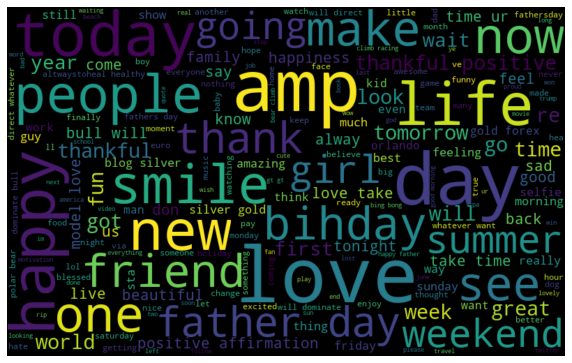

In [12]:
nonracist_tweet=train_df[(train_df['label']==0)] #selecting all the non racist tweets from the training set
all_words = ' '.join([text for text in nonracist_tweet['tweet']]) #populating all words with non racist words
from wordcloud import WordCloud
wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(all_words)

plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

# Word cloud for Racist tweets

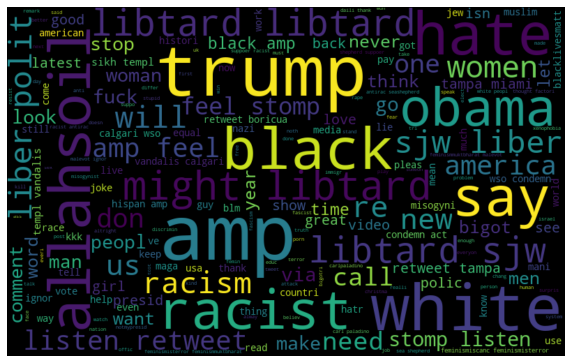

In [13]:
racist_tw=train[(train['label']==1)]#selecting all the racist tweets from the training set.
all_words = ' '.join([text for text in racist_tw['final_t']]) #populating the variable with racist tweet words.
from wordcloud import WordCloud
wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(all_words)

plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

# Preparing the predictors 

In [14]:
predictor = CountVectorizer(max_df=0.90, min_df=2, max_features=1000, stop_words='english')
x = predictor.fit_transform(train['final_t']).toarray() #converting the feature to an array
x.shape

(31962, 1000)

In [15]:
y=train['label']
le = LabelEncoder()
y = le.fit_transform(y)
y.shape

(31962,)

# Training the model

In [16]:
from sklearn.tree import DecisionTreeClassifier
DTree = DecisionTreeClassifier(criterion="entropy", max_depth = 10)
DTree.fit(x,y)
print("-----------------DECISION TREE CLASSIFIER---------------------")
print("Train set Accuracy: ", metrics.accuracy_score(y, DTree.predict(x)))

-----------------DECISION TREE CLASSIFIER---------------------
Train set Accuracy:  0.9463738189099555


In [17]:
from sklearn.linear_model import LogisticRegression
LR = LogisticRegression(C=1, solver='liblinear').fit(x,y)
print("------------------LOGISTIC REGRESSION---------------------")
print("Train set Accuracy: ", metrics.accuracy_score(y, LR.predict(x)))

------------------LOGISTIC REGRESSION---------------------
Train set Accuracy:  0.952287090920468


In [18]:
LR = LogisticRegression(C=502, solver='liblinear').fit(x,y) #502 cause it makes a minute difference
print("------------------LOGISTIC REGRESSION---------------------")
print("Train set Accuracy: ", metrics.accuracy_score(y, LR.predict(x)))

------------------LOGISTIC REGRESSION---------------------
Train set Accuracy:  0.9557599649583881


In [19]:
testdf = test.drop(['tokenwd','cleanedt','stemed','id'],axis=1)
testdf.head()

,tweet,final_t
0,studiolife aislife requires passion dedication...,studiolif aislif requir passion dedic willpow ...
1,white supremacists want everyone to see the ne...,white supremacist want everyon see new bird movi
2,safe ways to heal your acne altwaystoheal...,safe way heal acn altwaystoh healthi heal
3,is the hp and the cursed child book up for res...,hp curs child book reserv alreadi ye harrypott...
4,rd bihday to my amazing hilarious nephew eli ...,rd bihday amaz hilari nephew eli ahmir uncl da...


In [20]:
predictor = CountVectorizer(max_df=0.90, min_df=2, max_features=1000, stop_words='english')
x1 = predictor.fit_transform(testdf['final_t']).toarray()
x1.shape

(17197, 1000)

Make a new label column for test set as well

In [21]:
testdf['label'] = 0

No of racist tweets predicted by our model

In [22]:
testdf['label'].sum() #current sum of racist tweets

0

In [23]:
LR.predict(x1).sum()

824

In [24]:
testdf['label'][testdf['label']==0]=LR.predict(x1)

C:\Users\91901\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [25]:
testdf['label'].sum() #updated values for each racist tweet predicted.

824

# Word cloud for racist tweets in test set

In [26]:
racist_tw=testdf[(testdf['label']==1)]
racist_tw.head()

,tweet,final_t,label
20,hey guys tommorow is the last day of my exams ...,hey guy tommorow last day exam happi yay,1
47,morning sunshine smile sexy bigboobs,morn sunshin smile sexi bigboob,1
55,throw back thursday bih day my bro chege,throw back thursday bih day bro chege,1
63,have a very good sunday everyone ...,good sunday everyon sunday morn smile picoftheday,1
85,happy father s day fathers day ...,happi father day father day fathersday dad ilo...,1


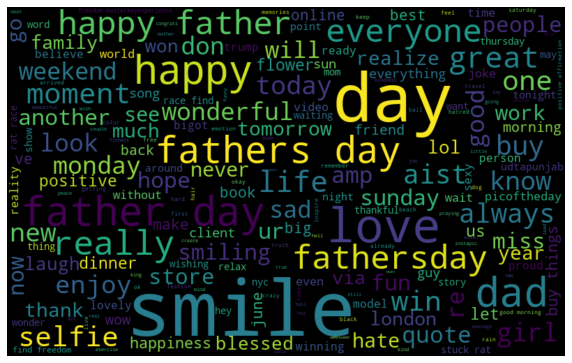

In [27]:
racist_tw=testdf[(testdf['label']==1)] #selecting the all the predicted racist tweets. 
all_words = ' '.join([text for text in racist_tw['tweet']]) #popoulating the all words variable with racist words.
wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(all_words)

plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show() 

# Word cloud for non racist tweets in the test set

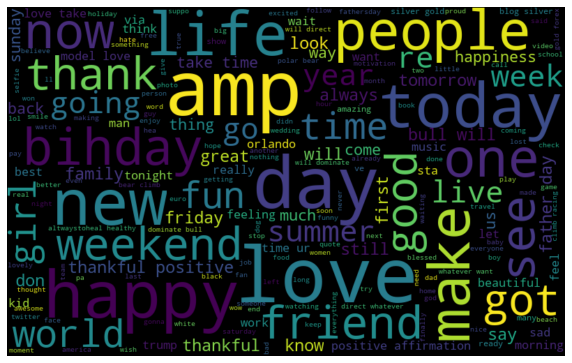

In [25]:
nonracist_tweet=testdf[(testdf['label']==0)] #selecting the non racist tweets from test set.
all_words = ' '.join([text for text in nonracist_tweet['tweet']]) #populating all words variable with non racisst words.
wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(all_words)

plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

Thus we have our racist and non racist tweets from the test set